## Quantizer Inference

In [1]:
%cd "/content/drive/MyDrive/TIDLLM"

/content/drive/MyDrive/TIDLLM


In [ ]:
!pip install -r requirements.txt

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import tqdm
import glob
import matplotlib.pyplot as plt

import mediapipe as mp

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from lib.utils.pose import *
import tarfile


In [5]:
def get_pose_array(SAMPLE_POSE):
    """Converts the pose data into a numpy array
    """

    POSE_RAW = pd.DataFrame(SAMPLE_POSE['pose'])
    RIGHT_HAND_RAW = pd.DataFrame(SAMPLE_POSE['right'])
    LEFT_HAND_RAW = pd.DataFrame(SAMPLE_POSE['left'])

    POSE_DF = {}

    for col in POSE_RAW.columns:
        POSE_DF[ 'POSE_' + col + '_X'] = POSE_RAW[col].apply(lambda x: x[0])
        POSE_DF[ 'POSE_' + col + '_Y'] = POSE_RAW[col].apply(lambda x: x[1])

    for col in RIGHT_HAND_RAW.columns:
        POSE_DF[ 'RIGHT_' + col + '_X' ] = RIGHT_HAND_RAW[col].apply(lambda x: x[0])
        POSE_DF[ 'RIGHT_' + col + '_Y' ] = RIGHT_HAND_RAW[col].apply(lambda x: x[1])

    for col in LEFT_HAND_RAW.columns:
        POSE_DF[ 'LEFT_' + col + '_X' ] = LEFT_HAND_RAW[col].apply(lambda x: x[0])
        POSE_DF[ 'LEFT_' + col + '_Y' ] = LEFT_HAND_RAW[col].apply(lambda x: x[1])

    POSE_DF = pd.DataFrame(POSE_DF)

    return POSE_DF


def get_matrices(POSE_DF):
    """Converts the pose data into a numpy array of distance matrices
    """
    x_cols = [col for col in POSE_DF.columns if col.endswith('_X')]
    y_cols = [col for col in POSE_DF.columns if col.endswith('_Y')]

    frames = []
    for i in range(1, POSE_DF.shape[0]):
        x_row = POSE_DF[x_cols].iloc[i].to_numpy()
        y_row = POSE_DF[y_cols].iloc[i].to_numpy()

        def get_difference_matrix(row):
            m, n = np.meshgrid(row, row)
            out = m-n
            return out

        x_diff = get_difference_matrix(x_row)
        y_diff = get_difference_matrix(y_row)

        frame = np.stack([x_diff, y_diff], axis=2)
        frames.append(frame)

    frames = np.stack(frames, axis=0)
    return frames

In [6]:
class Quantizer(nn.Module):
    """
    Quantizer for Continuous Sign Language Recognition

    Args:
        quantizer (nn.Module): base vq-vae based quantizer model
        num_frames (int): number of frames to consider
        stride (int): stride of the sliding window

    ### A. Usage:

    Define the quantizer model

    ```python
    quantizer = Quantizer(quantizer, num_frames=25, stride=1)
    quantized, indices = quantizer.quantize(x)
    ```

    If you want to transform the indices into one-hot, set `transform=True`

    ```python
    quantized, indices = quantizer.quantize(x, transform=True)
    ```

    Also process the video to get the pose estimation

    ```python
    x = Quantizer.process_video(video_path)
    ```
    """

    def __init__(self,
                 base_model,
                 num_frames=25,
                 stride=1,
                 num_codebooks=1,
                 codebook_size=512):
        super(Quantizer, self).__init__()

        self.quantizer = torch.load(
            base_model,
            map_location=torch.device('cpu' if not torch.cuda.is_available() else 'cuda:0')
        )

        self.quantizer.eval()

        self.num_frames = num_frames
        self.stride = stride

        self.codebook_size = codebook_size
        self.num_codebooks = num_codebooks

    @torch.no_grad()
    def encode(self, x):
        x_hat = self.quantizer.encoder(x)
        quantized, indices, _ = self.quantizer.vq_vae(x_hat)
        return quantized, indices

    def quantize(self, x, transform=False):
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        # NOTE: x.shape = (B, C, D, H, W)
        # Slice input channels
        x = x[:, :self.quantizer.encoder.input_size[1], :, :, :]
        quantized, indices = self.encode(x)
        if transform:
            indices = indices.view(-1, self.num_codebooks)
            # turn indices into one-hot
            indices = F.one_hot(indices, num_classes= self.num_codebooks * self.codebook_size).float()

        return quantized, indices

    def process_video(self, video_path: str):

        pose, _ = get_pose_estimation(video_path)
        pose_array = get_pose_array(pose)
        # Replace missing values with zeros
        pose_array = pose_array.replace(np.nan, 0)
        matrices = get_matrices(pose_array)

        # Generate overlapping windows
        windows = []
        for i in range(0, len(matrices) - self.num_frames, self.stride):
            window = matrices[i:i+self.num_frames]
            windows.append(window)

        # Convert to tensor
        data = torch.tensor(windows).float()

        return data

    def process_pose(self, pose_array):

        pose_array = pose_array.replace(np.nan, 0)
        matrices = get_matrices(pose_array)

        # Generate overlapping windows
        windows = []
        for i in range(0, len(matrices) - self.num_frames, self.stride):
            window = matrices[i:i+self.num_frames]
            windows.append(window)

        # Convert to tensor
        data = torch.tensor(windows).float()

        return data

In [ ]:
quantizer = Quantizer(
    base_model='quantizer/encoder.pt',
    num_frames=25,
    stride=10,
    num_codebooks=5,
    codebook_size=128,
)

In [ ]:
def open_tarfile(tarfile_name, output_dir):
    # open file
    file = tarfile.open(tarfile_name)

    # extracting file
    file.extractall(output_dir)

    file.close()

open_tarfile('/content/drive/MyDrive/TIDLLM/dataset/bsign22k/skeleton_openpose.tar.gz', '/content/videos')

### Getting Inferences

In [ ]:
def get_pose_dict_from_pickle(src_file):

    obj = pd.read_pickle(src_file)

    pose_transforms = {
        'NOSE': list(obj['pose']['nose']),
        'LEFT_EYE_INNER': list(obj['face']['left_eye_42']),
        'LEFT_EYE': list(obj['pose']['left_eye']),
        'LEFT_EYE_OUTER': list(obj['face']['left_eye_45']),
        'RIGHT_EYE_INNER': list(obj['face']['right_eye_39']),
        'RIGHT_EYE': list(obj['pose']['right_eye']),
        'RIGHT_EYE_OUTER': list(obj['face']['right_eye_36']),
        'LEFT_EAR': list(obj['pose']['left_ear']),
        'RIGHT_EAR': list(obj['pose']['right_ear']),
        'MOUTH_LEFT': list(obj['face']['mouth_54']),
        'MOUTH_RIGHT': list(obj['face']['mouth_48']),
        'LEFT_SHOULDER': list(obj['pose']['left_shoulder']),
        'RIGHT_SHOULDER': list(obj['pose']['right_shoulder']),
        'LEFT_ELBOW': list(obj['pose']['left_elbow']),
        'RIGHT_ELBOW': list(obj['pose']['right_elbow']),
        'LEFT_WRIST': list(obj['pose']['left_wrist']),
        'RIGHT_WRIST': list(obj['pose']['right_wrist']),
        'LEFT_PINKY': list(obj['hand_left']['little_finger_20']),
        'RIGHT_PINKY': list(obj['hand_right']['little_finger_20']),
        'LEFT_INDEX': list(obj['hand_left']['index_finger_8']),
        'RIGHT_INDEX': list(obj['hand_right']['index_finger_8']),
        'LEFT_THUMB': list(obj['hand_left']['thumb_4']),
        'RIGHT_THUMB': list(obj['hand_right']['thumb_4']),
        'LEFT_HIP': list(obj['pose']['left_hip']),
        'RIGHT_HIP': list(obj['pose']['right_hip']),
        'LEFT_KNEE': list(obj['pose']['left_knee']),
        'RIGHT_KNEE': list(obj['pose']['right_knee']),
        'LEFT_ANKLE': list(obj['pose']['left_ankle']),
        'RIGHT_ANKLE': list(obj['pose']['right_ankle']),
        'LEFT_HEEL': list(obj['pose']['left_heel']),
        'RIGHT_HEEL': list(obj['pose']['right_heel']),
        'LEFT_FOOT_INDEX': list(obj['pose']['left_big_toe']),
        'RIGHT_FOOT_INDEX': list(obj['pose']['right_big_toe'])
    }

    lefthand_transforms = {
        'WRIST': list(obj['hand_left']['lunate_bone']),
        'THUMB_CMC': list(obj['hand_left']['thumb_1']),
        'THUMB_MCP': list(obj['hand_left']['thumb_2']),
        'THUMB_IP': list(obj['hand_left']['thumb_3']),
        'THUMB_TIP': list(obj['hand_left']['thumb_4']),
        'INDEX_FINGER_MCP': list(obj['hand_left']['index_finger_5']),
        'INDEX_FINGER_PIP': list(obj['hand_left']['index_finger_6']),
        'INDEX_FINGER_DIP': list(obj['hand_left']['index_finger_7']),
        'INDEX_FINGER_TIP': list(obj['hand_left']['index_finger_8']),
        'MIDDLE_FINGER_MCP': list(obj['hand_left']['middle_finger_9']),
        'MIDDLE_FINGER_PIP': list(obj['hand_left']['middle_finger_10']),
        'MIDDLE_FINGER_DIP': list(obj['hand_left']['middle_finger_11']),
        'MIDDLE_FINGER_TIP': list(obj['hand_left']['middle_finger_12']),
        'RING_FINGER_MCP': list(obj['hand_left']['ring_finger_13']),
        'RING_FINGER_PIP': list(obj['hand_left']['ring_finger_14']),
        'RING_FINGER_DIP': list(obj['hand_left']['ring_finger_15']),
        'RING_FINGER_TIP': list(obj['hand_left']['ring_finger_16']),
        'PINKY_MCP': list(obj['hand_left']['little_finger_17']),
        'PINKY_PIP': list(obj['hand_left']['little_finger_18']),
        'PINKY_DIP': list(obj['hand_left']['little_finger_19']),
        'PINKY_TIP': list(obj['hand_left']['little_finger_20']),
    }

    righthand_transforms = {
        'WRIST': list(obj['hand_right']['lunate_bone']),
        'THUMB_CMC': list(obj['hand_right']['thumb_1']),
        'THUMB_MCP': list(obj['hand_right']['thumb_2']),
        'THUMB_IP': list(obj['hand_right']['thumb_3']),
        'THUMB_TIP': list(obj['hand_right']['thumb_4']),
        'INDEX_FINGER_MCP': list(obj['hand_right']['index_finger_5']),
        'INDEX_FINGER_PIP': list(obj['hand_right']['index_finger_6']),
        'INDEX_FINGER_DIP': list(obj['hand_right']['index_finger_7']),
        'INDEX_FINGER_TIP': list(obj['hand_right']['index_finger_8']),
        'MIDDLE_FINGER_MCP': list(obj['hand_right']['middle_finger_9']),
        'MIDDLE_FINGER_PIP': list(obj['hand_right']['middle_finger_10']),
        'MIDDLE_FINGER_DIP': list(obj['hand_right']['middle_finger_11']),
        'MIDDLE_FINGER_TIP': list(obj['hand_right']['middle_finger_12']),
        'RING_FINGER_MCP': list(obj['hand_right']['ring_finger_13']),
        'RING_FINGER_PIP': list(obj['hand_right']['ring_finger_14']),
        'RING_FINGER_DIP': list(obj['hand_right']['ring_finger_15']),
        'RING_FINGER_TIP': list(obj['hand_right']['ring_finger_16']),
        'PINKY_MCP': list(obj['hand_right']['little_finger_17']),
        'PINKY_PIP': list(obj['hand_right']['little_finger_18']),
        'PINKY_DIP': list(obj['hand_right']['little_finger_19']),
        'PINKY_TIP': list(obj['hand_right']['little_finger_20']),
    }

    pose_arr = {'pose': pose_transforms, 'left': lefthand_transforms, 'right': righthand_transforms}

    return pose_arr

In [ ]:
pose_arr = get_pose_dict_from_pickle('0005/User_2_001.pickle')
pose_arr = get_pose_array(pose_arr)
data = quantizer.process_pose(pose_arr)
quantized, indices = quantizer.quantize(data.to('cuda:0'))

In [ ]:
quantized.shape, indices.shape

(torch.Size([8, 768]), torch.Size([8, 5]))

In [ ]:
classes = pd.read_csv(f"/content/drive/MyDrive/TIDLLM/dataset/bsign22k/BosphorusSign22k_classes.csv")

classes = classes[classes['SubsetID'] == 'General']
general_gloss = classes['ClassID'].to_list()

In [ ]:
BASE_PATH = "/content/videos/skeleton_openpose"
PATH_TO_SAVE_TRAIN = "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/pose_array2/train/"
PATH_TO_SAVE_TEST = "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/pose_array2/test/"

def read_files(src_folder):
    glosses = sorted(os.listdir(src_folder))

    for gloss in tqdm.tqdm(glosses):
        gloss_path = BASE_PATH+"/"+gloss
        prev_user = ""
        user4_saved = False
        if int(gloss) not in general_gloss:
            continue
        print("\nGloss: ", gloss)
        for vid in sorted(os.listdir(gloss_path)):

            post_dict = get_pose_dict_from_pickle(f"{BASE_PATH}/{gloss}/{vid}")
            pose_arr = get_pose_array(post_dict)

            if vid.startswith("User_4"):
                if not os.path.exists(f"{PATH_TO_SAVE_TEST}{gloss}"):
                    os.makedirs(f"{PATH_TO_SAVE_TEST}{gloss}")

                if os.path.exists(f"{PATH_TO_SAVE_TEST}{gloss}/{vid.split('.')[0]}.npy"):
                    continue
                pose_data = quantizer.process_pose(pose_arr)
                quantized, indices = quantizer.quantize(pose_data.to('cuda:0'))
                np.save(f"{PATH_TO_SAVE_TEST}{gloss}/{vid.split('.')[0]}.npy", quantized.detach().cpu().numpy())
            else:
                if not os.path.exists(f"{PATH_TO_SAVE_TRAIN}{gloss}"):
                    os.makedirs(f"{PATH_TO_SAVE_TRAIN}{gloss}")

                if os.path.exists(f"{PATH_TO_SAVE_TRAIN}{gloss}/{vid.split('.')[0]}.npy"):
                    continue
                pose_data = quantizer.process_pose(pose_arr)
                quantized, indices = quantizer.quantize(pose_data.to('cuda:0'))
                np.save(f"{PATH_TO_SAVE_TRAIN}{gloss}/{vid.split('.')[0]}.npy", quantized.detach().cpu().numpy())

read_files(BASE_PATH)

## Gloss Classifier Training

### Analysis of Inferred Data

In [ ]:
glosses = sorted(os.listdir(PATH2))
seq = []
is_train = False
for gloss in sorted(os.listdir(PATH2)):
    gloss_path = PATH2+"/"+gloss
    user4_saved = False
    if int(gloss) not in general_gloss:
        continue
    for vid in sorted(os.listdir(gloss_path)):
        if is_train:
            if vid.startswith("User_4"):
                continue
        else:
            if not vid.startswith("User_4"):
                continue
        seq.append(f"{PATH2}/{gloss}/{vid}")

In [ ]:
g_gloss_files = []

for gloss in general_gloss:
    files = sorted(glob.glob(f"{PATH}/train/{gloss:04}"))
    for f in files:
        for npy in sorted(glob.glob(f"{f}/*.npy")):
            g_gloss_files.append(npy)


In [ ]:
asd = {f"{general_gloss[i]:04}": i for i in range(len(general_gloss))}
max(asd.values())

154

In [12]:
PATH = "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/pose_array2"
# PATH2 = "/content/videos/skeleton_openpose"

In [17]:
classes = pd.read_csv(f"/content/drive/MyDrive/TIDLLM/dataset/bsign22k/BosphorusSign22k_classes.csv")

classes = classes[classes['SubsetID'] == 'General']
general_gloss = classes['ClassID'].to_list()

### Subset Gloss

In [ ]:
classes = pd.read_csv(f"/content/drive/MyDrive/TIDLLM/dataset/bsign22k/BosphorusSign22k_classes.csv")

classes = classes[classes['SubsetID'] == 'General']
general_gloss = classes['ClassID'].to_list()

### Data Loader & Model

In [18]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import glob
from torch.nn.utils.rnn import pad_sequence

class PoseDistanceDataset(Dataset):
    def __init__(self, data_src, is_train):
        self.base_path = data_src
        self.is_train = is_train
        self.sequences = sorted(glob.glob(f"{self.base_path}/{'train' if is_train else 'test'}/*/*.npy"))
        self.gloss2idx = {f"{general_gloss[i]:04}": i for i in range(len(general_gloss))}
        self.max_size = 13

    def __len__(self):
        return len(self.sequences)


    def __getitem__(self, idx):
        item_src = self.sequences[idx]
        item_class = self.gloss2idx[item_src.split("/")[-2]]

        encoded_arr = torch.tensor(np.load(item_src))
        return encoded_arr, torch.tensor(item_class)


    @staticmethod
    def collate_fn(batch):
        tensors, targets = zip(*batch)
        tensors = list(tensors)
        # arr = pad_sequence(tensors, batch_first=True, padding_value=0)
        tensors[0] = nn.ConstantPad2d((0, 0, 0, 16 - tensors[0].shape[0]), 0)(tensors[0])
        arr = pad_sequence(tensors, batch_first=True, padding_value=0)
        labels = torch.stack(targets)

        return arr, labels

In [ ]:
train_dataset = PoseDistanceDataset(PATH, True)
eval_dataset = PoseDistanceDataset(PATH, False)
# train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=42)
# len(train_dataset), len(val_dataset)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=PoseDistanceDataset.collate_fn)
val_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=True, collate_fn=PoseDistanceDataset.collate_fn)

In [ ]:
x,y = next(iter(val_dataloader))
print(x.shape, y.shape)

torch.Size([16, 768])
torch.Size([64, 16, 768]) torch.Size([64])


In [ ]:
y

tensor([ 69, 120,   2,  83,  21, 135, 141,  32, 142,  84, 110,   3,  86, 140,
         91,   6, 109,  33, 141,  71, 104,  62, 105,  39,  11,  42,  30, 115,
         19,  63,  78,  66,  34,  38,  91,  62, 113, 144,  82,   4,  43,  17,
         13,  15,  34,  27, 135, 114,   4,  33,  14,  74,  57, 104,  38,  10,
         16,  90, 123,  90,   0,  58,  89, 128])

(BATCH, FRAME, 768)

In [8]:
class GlossClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, out_size):
        super(GlossClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.out_size = out_size

        ## input_size=frame, out_size=new_frame
        self.conv1d_1 = nn.Conv1d(in_channels=input_size, out_channels=input_size, kernel_size=3, stride=2)
        self.conv1d_2 = nn.Conv1d(in_channels=input_size, out_channels=input_size, kernel_size=3, stride=2)
        self.lstm = nn.LSTM(191, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_size)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # x = self.dropout(x)
        x = self.relu(self.conv1d_1(x))
        x = self.relu(self.conv1d_2(x))
        out, (ht, ct) = self.lstm(x, (h0, c0))
        return self.linear(ht[-1])


In [ ]:
def training(model, num_epochs, lr, train_dataloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, min_lr=1e-8)
    train_losses = []
    prev_loss = 9999999
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        val_acc = 0.0
        model.train()
        for input, label in tqdm.tqdm(train_dataloader):
            input, label = input.to(DEVICE), label.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input)
            loss = criterion(outputs, label)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        # scheduler.step()
        scheduler.step(train_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_dataloader)}')
        train_losses.append(train_loss/len(train_dataloader))

        if(train_loss/len(train_dataloader) < prev_loss):
            print("Saving model...")
            torch.save(model, PATH+f"/models/{epoch}_entire_model.pt")
            prev_loss = min(train_loss/len(train_dataloader), prev_loss)
    return model, train_losses


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GlossClassifier(16, 32, 2, 155) ## 154 general glosses, 744 all glosses
model = model.to(DEVICE)

NUM_EPOCHS = 300
LR=1e-2

model, train_losses = training(model=model, num_epochs=NUM_EPOCHS, lr=LR, train_dataloader=train_dataloader, val_dataloader=None)

100%|██████████| 68/68 [00:11<00:00,  6.02it/s]


Epoch [1/300], Train Loss: 5.042164739440469
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [2/300], Train Loss: 5.019557328785167
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.95it/s]


Epoch [3/300], Train Loss: 5.016704068464391
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Epoch [4/300], Train Loss: 4.990356746841879
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.71it/s]


Epoch [5/300], Train Loss: 4.9750725101022155
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


Epoch [6/300], Train Loss: 4.658163891119115
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [7/300], Train Loss: 4.5024434959187225
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.00it/s]


Epoch [8/300], Train Loss: 4.3642670126522285
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [9/300], Train Loss: 4.298607601838953
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [10/300], Train Loss: 4.243010422762702
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [11/300], Train Loss: 4.252047959495993


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [12/300], Train Loss: 4.184046163278468
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


Epoch [13/300], Train Loss: 4.1324129805845375
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [14/300], Train Loss: 4.154516188537373


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [15/300], Train Loss: 4.15807419314104


100%|██████████| 68/68 [00:11<00:00,  5.76it/s]


Epoch [16/300], Train Loss: 4.101287161602693
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Epoch [17/300], Train Loss: 4.186458854114308


100%|██████████| 68/68 [00:11<00:00,  6.00it/s]


Epoch [18/300], Train Loss: 4.11208813681322


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [19/300], Train Loss: 4.086329705574933
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [20/300], Train Loss: 4.3182646597132965


100%|██████████| 68/68 [00:11<00:00,  6.00it/s]


Epoch [21/300], Train Loss: 4.19925782961004


100%|██████████| 68/68 [00:11<00:00,  6.13it/s]


Epoch [22/300], Train Loss: 4.147395225132213


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [23/300], Train Loss: 4.151834323125727


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


Epoch [24/300], Train Loss: 4.13459450006485


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [25/300], Train Loss: 4.110525849987479


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [26/300], Train Loss: 4.0960917262470025


100%|██████████| 68/68 [00:11<00:00,  6.05it/s]


Epoch [27/300], Train Loss: 4.106852335088393


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [28/300], Train Loss: 4.063382629085989
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.09it/s]


Epoch [29/300], Train Loss: 4.052211319699007
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


Epoch [30/300], Train Loss: 4.063217783675475


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [31/300], Train Loss: 4.042890264707453
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [32/300], Train Loss: 4.0175886364544136
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


Epoch [33/300], Train Loss: 3.975706843768849
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


Epoch [34/300], Train Loss: 3.9729508336852577
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [35/300], Train Loss: 3.96177702440935
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.19it/s]


Epoch [36/300], Train Loss: 4.014146310441634


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [37/300], Train Loss: 3.9445632380597733
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [38/300], Train Loss: 3.9390999779981724
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [39/300], Train Loss: 3.9561880406211403


100%|██████████| 68/68 [00:11<00:00,  6.07it/s]


Epoch [40/300], Train Loss: 4.0974225997924805


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


Epoch [41/300], Train Loss: 3.9879782410228954


100%|██████████| 68/68 [00:11<00:00,  6.08it/s]


Epoch [42/300], Train Loss: 3.959153589080362


100%|██████████| 68/68 [00:11<00:00,  6.09it/s]


Epoch [43/300], Train Loss: 3.9789404658710255


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [44/300], Train Loss: 4.045513973516576


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [45/300], Train Loss: 3.9616027228972492


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [46/300], Train Loss: 3.923107655609355
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [47/300], Train Loss: 3.924760376705843


100%|██████████| 68/68 [00:11<00:00,  5.99it/s]


Epoch [48/300], Train Loss: 3.906625411089729
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [49/300], Train Loss: 3.8996344945010017
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [50/300], Train Loss: 3.878671919598299
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


Epoch [51/300], Train Loss: 3.8901499299442066


100%|██████████| 68/68 [00:11<00:00,  5.78it/s]


Epoch [52/300], Train Loss: 3.8556028955123005
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [53/300], Train Loss: 3.9328820214552036


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [54/300], Train Loss: 3.855330130633186
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [55/300], Train Loss: 3.8842511457555435


100%|██████████| 68/68 [00:11<00:00,  5.95it/s]


Epoch [56/300], Train Loss: 4.214892303242403


100%|██████████| 68/68 [00:11<00:00,  6.12it/s]


Epoch [57/300], Train Loss: 3.9394687519353977


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [58/300], Train Loss: 3.937923150904038


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [59/300], Train Loss: 3.884283893248614


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [60/300], Train Loss: 3.8716122893726124


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [61/300], Train Loss: 3.904055083499235


100%|██████████| 68/68 [00:11<00:00,  6.05it/s]


Epoch [62/300], Train Loss: 3.832251117509954
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.09it/s]


Epoch [63/300], Train Loss: 3.834930377848008


100%|██████████| 68/68 [00:11<00:00,  6.12it/s]


Epoch [64/300], Train Loss: 3.8301545907469357
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.13it/s]


Epoch [65/300], Train Loss: 3.821362463866963
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [66/300], Train Loss: 3.806014902451459
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [67/300], Train Loss: 3.7902580113971935
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [68/300], Train Loss: 3.8164344535154453


100%|██████████| 68/68 [00:11<00:00,  6.05it/s]


Epoch [69/300], Train Loss: 3.8326176299768338


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [70/300], Train Loss: 3.8164375284138847


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [71/300], Train Loss: 3.7725335044019364
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [72/300], Train Loss: 3.761751073248246
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [73/300], Train Loss: 3.7414962859714733
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [74/300], Train Loss: 3.757063728921554


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


Epoch [75/300], Train Loss: 3.7934798633351043


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


Epoch [76/300], Train Loss: 3.735423477256999
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [77/300], Train Loss: 3.726258172708399
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [78/300], Train Loss: 3.734716194517472


100%|██████████| 68/68 [00:11<00:00,  5.99it/s]


Epoch [79/300], Train Loss: 3.7759464558433082


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


Epoch [80/300], Train Loss: 3.810993369887857


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [81/300], Train Loss: 3.732782342854668


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [82/300], Train Loss: 3.72492854384815
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.94it/s]


Epoch [83/300], Train Loss: 3.6669534304562736
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [84/300], Train Loss: 3.823085571036619


100%|██████████| 68/68 [00:11<00:00,  6.14it/s]


Epoch [85/300], Train Loss: 3.688411593437195


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


Epoch [86/300], Train Loss: 3.675988835446975


100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Epoch [87/300], Train Loss: 3.7265678188380074


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [88/300], Train Loss: 3.674284675542046


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [89/300], Train Loss: 3.631491513813243
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [90/300], Train Loss: 3.708945095539093


100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Epoch [91/300], Train Loss: 3.6797369052382076


100%|██████████| 68/68 [00:11<00:00,  6.10it/s]


Epoch [92/300], Train Loss: 3.812384111039779


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [93/300], Train Loss: 3.671387388425715


100%|██████████| 68/68 [00:11<00:00,  5.99it/s]


Epoch [94/300], Train Loss: 3.6309108769192413
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [95/300], Train Loss: 3.660064935684204


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [96/300], Train Loss: 3.603582343634437
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [97/300], Train Loss: 3.613332345205195


100%|██████████| 68/68 [00:11<00:00,  6.05it/s]


Epoch [98/300], Train Loss: 3.6720407079247868


100%|██████████| 68/68 [00:11<00:00,  6.14it/s]


Epoch [99/300], Train Loss: 3.5969189791118397
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.15it/s]


Epoch [100/300], Train Loss: 3.5999106834916508


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [101/300], Train Loss: 3.582463832462535
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.77it/s]


Epoch [102/300], Train Loss: 3.5875821429140426


100%|██████████| 68/68 [00:11<00:00,  5.95it/s]


Epoch [103/300], Train Loss: 3.649650373879601


100%|██████████| 68/68 [00:11<00:00,  6.11it/s]


Epoch [104/300], Train Loss: 3.5872704246464897


100%|██████████| 68/68 [00:11<00:00,  6.07it/s]


Epoch [105/300], Train Loss: 3.8754215836524963


100%|██████████| 68/68 [00:11<00:00,  5.94it/s]


Epoch [106/300], Train Loss: 3.620710972477408


100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Epoch [107/300], Train Loss: 3.6498898653423084


100%|██████████| 68/68 [00:11<00:00,  6.00it/s]


Epoch [108/300], Train Loss: 3.576909205492805
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [109/300], Train Loss: 3.642896091236788


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [110/300], Train Loss: 3.6227326603496777


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [111/300], Train Loss: 3.5680251366951885
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [112/300], Train Loss: 3.5391226551112007
Saving model...


100%|██████████| 68/68 [00:12<00:00,  5.50it/s]


Epoch [113/300], Train Loss: 3.5326375996365265
Saving model...


100%|██████████| 68/68 [00:12<00:00,  5.41it/s]


Epoch [114/300], Train Loss: 3.520584201111513
Saving model...


100%|██████████| 68/68 [00:12<00:00,  5.60it/s]


Epoch [115/300], Train Loss: 3.550191135967479


100%|██████████| 68/68 [00:11<00:00,  5.70it/s]


Epoch [116/300], Train Loss: 3.498424232006073
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [117/300], Train Loss: 3.5014627365504993


100%|██████████| 68/68 [00:11<00:00,  5.78it/s]


Epoch [118/300], Train Loss: 3.569359432248508


100%|██████████| 68/68 [00:12<00:00,  5.64it/s]


Epoch [119/300], Train Loss: 3.5146399245542637


100%|██████████| 68/68 [00:11<00:00,  6.08it/s]


Epoch [120/300], Train Loss: 3.4795393978848175
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [121/300], Train Loss: 3.516309110557332


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


Epoch [122/300], Train Loss: 3.516675146187053


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [123/300], Train Loss: 3.502804184661192


100%|██████████| 68/68 [00:11<00:00,  5.81it/s]


Epoch [124/300], Train Loss: 3.4628255788017723
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Epoch [125/300], Train Loss: 3.468541573075687


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [126/300], Train Loss: 3.4613497467602
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.16it/s]


Epoch [127/300], Train Loss: 3.4580448339967167
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


Epoch [128/300], Train Loss: 3.480178580564611


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


Epoch [129/300], Train Loss: 3.4709865485920623


100%|██████████| 68/68 [00:11<00:00,  5.78it/s]


Epoch [130/300], Train Loss: 3.5429334360010483


100%|██████████| 68/68 [00:11<00:00,  5.76it/s]


Epoch [131/300], Train Loss: 3.6666116644354427


100%|██████████| 68/68 [00:11<00:00,  5.77it/s]


Epoch [132/300], Train Loss: 3.452998473363764
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [133/300], Train Loss: 3.488443472806145


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [134/300], Train Loss: 3.3799225574030594
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.02it/s]


Epoch [135/300], Train Loss: 3.437418587067548


100%|██████████| 68/68 [00:11<00:00,  6.05it/s]


Epoch [136/300], Train Loss: 3.4356768937671887


100%|██████████| 68/68 [00:11<00:00,  6.00it/s]


Epoch [137/300], Train Loss: 3.4450547835406136


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


Epoch [138/300], Train Loss: 4.309807209407582


100%|██████████| 68/68 [00:11<00:00,  6.00it/s]


Epoch [139/300], Train Loss: 3.9119879007339478


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [140/300], Train Loss: 3.7252195652793434


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [141/300], Train Loss: 3.721091792863958


100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Epoch [142/300], Train Loss: 3.532686570111443


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [143/300], Train Loss: 3.4788891392595627


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [144/300], Train Loss: 3.527558018179501


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [145/300], Train Loss: 3.417085696669186


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [146/300], Train Loss: 3.3789201799560997
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.99it/s]


Epoch [147/300], Train Loss: 3.356364344849306
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [148/300], Train Loss: 3.309263324036318
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.07it/s]


Epoch [149/300], Train Loss: 3.367989627753987


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


Epoch [150/300], Train Loss: 3.3059288824305817
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.79it/s]


Epoch [151/300], Train Loss: 3.287107120541965
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.90it/s]


Epoch [152/300], Train Loss: 3.2884950532632717


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [153/300], Train Loss: 3.3140242836054634


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [154/300], Train Loss: 3.306799530982971


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [155/300], Train Loss: 3.3505103027119354


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [156/300], Train Loss: 3.296970125506906


100%|██████████| 68/68 [00:11<00:00,  6.01it/s]


Epoch [157/300], Train Loss: 3.261002970092437
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.81it/s]


Epoch [158/300], Train Loss: 3.292881874477162


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [159/300], Train Loss: 3.238236592096441
Saving model...


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [160/300], Train Loss: 3.309649036211126


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [161/300], Train Loss: 3.244065722998451


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [162/300], Train Loss: 3.250879936358508


100%|██████████| 68/68 [00:11<00:00,  5.94it/s]


Epoch [163/300], Train Loss: 3.248454938916599


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [164/300], Train Loss: 3.2616035482462715


100%|██████████| 68/68 [00:12<00:00,  5.65it/s]


Epoch [165/300], Train Loss: 3.21863759615842
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [166/300], Train Loss: 3.203542274587295
Saving model...


100%|██████████| 68/68 [00:12<00:00,  5.53it/s]


Epoch [167/300], Train Loss: 3.2318518792881683


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [168/300], Train Loss: 3.1929106063702526
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.97it/s]


Epoch [169/300], Train Loss: 3.2358509512508618


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [170/300], Train Loss: 3.234211160856135


100%|██████████| 68/68 [00:11<00:00,  5.76it/s]


Epoch [171/300], Train Loss: 3.2190261167638443


100%|██████████| 68/68 [00:11<00:00,  5.71it/s]


Epoch [172/300], Train Loss: 3.17834314178018
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [173/300], Train Loss: 3.1997437827727375


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [174/300], Train Loss: 3.2224348818554596


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [175/300], Train Loss: 3.201374089016634


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [176/300], Train Loss: 3.248228967189789


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [177/300], Train Loss: 3.1860717394772697


100%|██████████| 68/68 [00:12<00:00,  5.64it/s]


Epoch [178/300], Train Loss: 3.199140233152053


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [179/300], Train Loss: 3.44065163416021


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [180/300], Train Loss: 3.256339034613441


100%|██████████| 68/68 [00:12<00:00,  5.59it/s]


Epoch [181/300], Train Loss: 3.1901825876796948


100%|██████████| 68/68 [00:12<00:00,  5.66it/s]


Epoch [182/300], Train Loss: 3.197905480861664


100%|██████████| 68/68 [00:11<00:00,  5.95it/s]


Epoch [183/300], Train Loss: 3.1454880483010235
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [184/300], Train Loss: 3.1874447219512043


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [185/300], Train Loss: 3.1676222208668205


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [186/300], Train Loss: 3.2853989355704365


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [187/300], Train Loss: 3.1465399230227753


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [188/300], Train Loss: 3.1566411467159496


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [189/300], Train Loss: 3.172047257423401


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [190/300], Train Loss: 3.1699097051339993


100%|██████████| 68/68 [00:11<00:00,  5.76it/s]


Epoch [191/300], Train Loss: 3.6702379864804886


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [192/300], Train Loss: 3.2137100591379055


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [193/300], Train Loss: 3.1609816410962273


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [194/300], Train Loss: 3.1663792413823746


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [195/300], Train Loss: 3.119586338015164
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [196/300], Train Loss: 3.088339345420108
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.07it/s]


Epoch [197/300], Train Loss: 3.0842891808818367
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


Epoch [198/300], Train Loss: 3.0808730440981247
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [199/300], Train Loss: 3.118631874813753


100%|██████████| 68/68 [00:11<00:00,  5.87it/s]


Epoch [200/300], Train Loss: 3.101737306398504


100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Epoch [201/300], Train Loss: 3.091527696918039


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [202/300], Train Loss: 3.1022172850721024


100%|██████████| 68/68 [00:11<00:00,  5.93it/s]


Epoch [203/300], Train Loss: 3.0952207691529217


100%|██████████| 68/68 [00:11<00:00,  5.99it/s]


Epoch [204/300], Train Loss: 3.0977136422606075


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [205/300], Train Loss: 3.0632432315717724
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.04it/s]


Epoch [206/300], Train Loss: 3.0314842260935726
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.02it/s]


Epoch [207/300], Train Loss: 3.077701477443471


100%|██████████| 68/68 [00:11<00:00,  6.11it/s]


Epoch [208/300], Train Loss: 3.0713194994365467


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [209/300], Train Loss: 3.025635572040782
Saving model...


100%|██████████| 68/68 [00:11<00:00,  6.06it/s]


Epoch [210/300], Train Loss: 3.0903333951445187


100%|██████████| 68/68 [00:11<00:00,  6.13it/s]


Epoch [211/300], Train Loss: 3.0608398142982933


100%|██████████| 68/68 [00:11<00:00,  6.03it/s]


Epoch [212/300], Train Loss: 3.049158012165743


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [213/300], Train Loss: 3.067562601145576


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [214/300], Train Loss: 3.069153943482567


100%|██████████| 68/68 [00:11<00:00,  6.02it/s]


Epoch [215/300], Train Loss: 3.045134621507981


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [216/300], Train Loss: 3.0446233293589424


100%|██████████| 68/68 [00:11<00:00,  5.98it/s]


Epoch [217/300], Train Loss: 3.0502321509753956


100%|██████████| 68/68 [00:11<00:00,  6.18it/s]


Epoch [218/300], Train Loss: 3.04862818998449


100%|██████████| 68/68 [00:11<00:00,  5.96it/s]


Epoch [219/300], Train Loss: 3.0679307615055755


100%|██████████| 68/68 [00:11<00:00,  5.88it/s]


Epoch [220/300], Train Loss: 3.0423214190146504


100%|██████████| 68/68 [00:11<00:00,  5.75it/s]


Epoch [221/300], Train Loss: 3.0194098423509037
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.67it/s]


Epoch [222/300], Train Loss: 3.025947427048403


100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Epoch [223/300], Train Loss: 3.011169854332419
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Epoch [224/300], Train Loss: 3.0219618607969845


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [225/300], Train Loss: 3.018194489619311


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [226/300], Train Loss: 2.9704805779106476
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [227/300], Train Loss: 3.0047426223754883


100%|██████████| 68/68 [00:12<00:00,  5.57it/s]


Epoch [228/300], Train Loss: 3.026785142281476


100%|██████████| 68/68 [00:11<00:00,  5.80it/s]


Epoch [229/300], Train Loss: 3.0221618203555836


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [230/300], Train Loss: 2.9603166770847404
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [231/300], Train Loss: 3.0223210664356457


100%|██████████| 68/68 [00:11<00:00,  5.75it/s]


Epoch [232/300], Train Loss: 3.013491591986488


100%|██████████| 68/68 [00:11<00:00,  5.77it/s]


Epoch [233/300], Train Loss: 3.0171924478867473


100%|██████████| 68/68 [00:11<00:00,  5.76it/s]


Epoch [234/300], Train Loss: 2.985296831411474


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [235/300], Train Loss: 2.999922373715569


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [236/300], Train Loss: 2.9712981353787815


100%|██████████| 68/68 [00:11<00:00,  5.89it/s]


Epoch [237/300], Train Loss: 3.003908609642702


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [238/300], Train Loss: 2.99508932057549


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [239/300], Train Loss: 2.9960032806676975


100%|██████████| 68/68 [00:12<00:00,  5.62it/s]


Epoch [240/300], Train Loss: 3.0172890775343952


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [241/300], Train Loss: 2.947233046459801
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.70it/s]


Epoch [242/300], Train Loss: 3.0002417669576755


100%|██████████| 68/68 [00:11<00:00,  5.77it/s]


Epoch [243/300], Train Loss: 2.987488055930418


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [244/300], Train Loss: 3.007081357871785


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [245/300], Train Loss: 3.0005048864028034


100%|██████████| 68/68 [00:12<00:00,  5.54it/s]


Epoch [246/300], Train Loss: 2.9496129356762943


100%|██████████| 68/68 [00:12<00:00,  5.32it/s]


Epoch [247/300], Train Loss: 3.0008363548447106


100%|██████████| 68/68 [00:12<00:00,  5.62it/s]


Epoch [248/300], Train Loss: 2.9697047927800346


100%|██████████| 68/68 [00:12<00:00,  5.65it/s]


Epoch [249/300], Train Loss: 2.989006715662339


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [250/300], Train Loss: 2.9925080993596245


100%|██████████| 68/68 [00:12<00:00,  5.51it/s]


Epoch [251/300], Train Loss: 2.971411347389221


100%|██████████| 68/68 [00:11<00:00,  5.75it/s]


Epoch [252/300], Train Loss: 2.974096228094662


100%|██████████| 68/68 [00:12<00:00,  5.59it/s]


Epoch [253/300], Train Loss: 2.971582023536458


100%|██████████| 68/68 [00:11<00:00,  5.67it/s]


Epoch [254/300], Train Loss: 2.94842672698638


100%|██████████| 68/68 [00:12<00:00,  5.65it/s]


Epoch [255/300], Train Loss: 2.96916099506266


100%|██████████| 68/68 [00:12<00:00,  5.61it/s]


Epoch [256/300], Train Loss: 2.96101411300547


100%|██████████| 68/68 [00:12<00:00,  5.60it/s]


Epoch [257/300], Train Loss: 3.0079527111614452


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [258/300], Train Loss: 2.9858680893393124


100%|██████████| 68/68 [00:11<00:00,  5.92it/s]


Epoch [259/300], Train Loss: 2.96036041133544


100%|██████████| 68/68 [00:11<00:00,  5.75it/s]


Epoch [260/300], Train Loss: 2.9614213319385754


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [261/300], Train Loss: 2.9701932563501248


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [262/300], Train Loss: 2.9726478071773754


100%|██████████| 68/68 [00:12<00:00,  5.66it/s]


Epoch [263/300], Train Loss: 2.9746519257040585


100%|██████████| 68/68 [00:11<00:00,  5.78it/s]


Epoch [264/300], Train Loss: 2.9710316833327797


100%|██████████| 68/68 [00:11<00:00,  5.91it/s]


Epoch [265/300], Train Loss: 2.9586240754407993


100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Epoch [266/300], Train Loss: 2.922759219127543
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.78it/s]


Epoch [267/300], Train Loss: 2.9127433247425976
Saving model...


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [268/300], Train Loss: 2.955658611129312


100%|██████████| 68/68 [00:11<00:00,  5.67it/s]


Epoch [269/300], Train Loss: 2.948657642392551


100%|██████████| 68/68 [00:11<00:00,  5.71it/s]


Epoch [270/300], Train Loss: 2.9474466478123382


100%|██████████| 68/68 [00:11<00:00,  5.78it/s]


Epoch [271/300], Train Loss: 2.9623573597739723


100%|██████████| 68/68 [00:11<00:00,  5.77it/s]


Epoch [272/300], Train Loss: 2.935056672376745


100%|██████████| 68/68 [00:12<00:00,  5.51it/s]


Epoch [273/300], Train Loss: 2.9590781190816093


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [274/300], Train Loss: 2.969401349039639


100%|██████████| 68/68 [00:11<00:00,  5.70it/s]


Epoch [275/300], Train Loss: 2.948715451885672


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [276/300], Train Loss: 2.94810648876078


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [277/300], Train Loss: 2.937590620096992


100%|██████████| 68/68 [00:12<00:00,  5.65it/s]


Epoch [278/300], Train Loss: 2.950365900993347


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [279/300], Train Loss: 2.942796090069939


100%|██████████| 68/68 [00:12<00:00,  5.61it/s]


Epoch [280/300], Train Loss: 2.968527345096364


100%|██████████| 68/68 [00:11<00:00,  5.68it/s]


Epoch [281/300], Train Loss: 2.9571428298950195


100%|██████████| 68/68 [00:11<00:00,  5.81it/s]


Epoch [282/300], Train Loss: 2.923311135348152


100%|██████████| 68/68 [00:11<00:00,  5.79it/s]


Epoch [283/300], Train Loss: 2.9388899627853844


100%|██████████| 68/68 [00:11<00:00,  5.74it/s]


Epoch [284/300], Train Loss: 2.9649527388460495


100%|██████████| 68/68 [00:11<00:00,  5.77it/s]


Epoch [285/300], Train Loss: 2.9682841967133915


100%|██████████| 68/68 [00:11<00:00,  5.67it/s]


Epoch [286/300], Train Loss: 2.9361453897812786


100%|██████████| 68/68 [00:12<00:00,  5.63it/s]


Epoch [287/300], Train Loss: 2.95273817988003


100%|██████████| 68/68 [00:12<00:00,  5.60it/s]


Epoch [288/300], Train Loss: 2.9540841579437256


100%|██████████| 68/68 [00:11<00:00,  5.71it/s]


Epoch [289/300], Train Loss: 2.942265748977661


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [290/300], Train Loss: 2.940873591338887


100%|██████████| 68/68 [00:11<00:00,  5.75it/s]


Epoch [291/300], Train Loss: 2.955728464266833


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [292/300], Train Loss: 2.9182941405212177


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [293/300], Train Loss: 2.9531128090970657


100%|██████████| 68/68 [00:12<00:00,  5.62it/s]


Epoch [294/300], Train Loss: 2.958902018911698


100%|██████████| 68/68 [00:11<00:00,  5.69it/s]


Epoch [295/300], Train Loss: 2.9637105850612415


100%|██████████| 68/68 [00:11<00:00,  5.68it/s]


Epoch [296/300], Train Loss: 2.9545123401810143


100%|██████████| 68/68 [00:11<00:00,  5.73it/s]


Epoch [297/300], Train Loss: 2.9534521102905273


100%|██████████| 68/68 [00:11<00:00,  5.72it/s]


Epoch [298/300], Train Loss: 2.9262148632722744


100%|██████████| 68/68 [00:12<00:00,  5.44it/s]


Epoch [299/300], Train Loss: 2.9489810326520134


100%|██████████| 68/68 [00:11<00:00,  5.81it/s]

Epoch [300/300], Train Loss: 2.9421651363372803


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GlossClassifier(16, 32, 2, 155) ## 154 general glosses, 744 all glosses
model = model.to(DEVICE)

NUM_EPOCHS = 500
LR=1e-2

model, train_losses = training(model=model, num_epochs=NUM_EPOCHS, lr=LR, train_dataloader=train_dataloader, val_dataloader=None)

100%|██████████| 68/68 [39:02<00:00, 34.45s/it]


Epoch [1/500], Train Loss: 5.04738060165854
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [2/500], Train Loss: 5.027582911884084
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [3/500], Train Loss: 5.028033950749566


100%|██████████| 68/68 [00:10<00:00,  6.75it/s]


Epoch [4/500], Train Loss: 5.016274536357207
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [5/500], Train Loss: 5.003825608421774
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [6/500], Train Loss: 4.9882276198443245
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [7/500], Train Loss: 4.976013372926151
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [8/500], Train Loss: 4.966063800980063
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.80it/s]


Epoch [9/500], Train Loss: 4.986244250746334


100%|██████████| 68/68 [00:10<00:00,  6.66it/s]


Epoch [10/500], Train Loss: 4.9653797780766205
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [11/500], Train Loss: 4.960448335198795
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [12/500], Train Loss: 4.958178751608905
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [13/500], Train Loss: 4.955443803001852
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [14/500], Train Loss: 4.947926970089183
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [15/500], Train Loss: 4.943480540724361
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [16/500], Train Loss: 4.937140962656806
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [17/500], Train Loss: 4.93974092427422


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [18/500], Train Loss: 4.935642123222351
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [19/500], Train Loss: 4.934867816812852
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.60it/s]


Epoch [20/500], Train Loss: 4.929120533606586
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [21/500], Train Loss: 4.920461409232196
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [22/500], Train Loss: 4.906591198023627
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [23/500], Train Loss: 4.931942308650298


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [24/500], Train Loss: 4.926167915849125


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [25/500], Train Loss: 4.910048358580646


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [26/500], Train Loss: 4.9222383569268615


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [27/500], Train Loss: 4.918210723820855


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [28/500], Train Loss: 4.919946333941291


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [29/500], Train Loss: 4.952347685309017


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [30/500], Train Loss: 4.930980310720556


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [31/500], Train Loss: 4.9181069205789


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [32/500], Train Loss: 4.917043503592996


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [33/500], Train Loss: 4.9549596309661865


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [34/500], Train Loss: 4.976020287064945


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [35/500], Train Loss: 4.927329645437353


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [36/500], Train Loss: 4.9124547032748955


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [37/500], Train Loss: 4.906024848713594
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [38/500], Train Loss: 4.890597083989312
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [39/500], Train Loss: 4.895000612034517


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [40/500], Train Loss: 4.904020751223845


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [41/500], Train Loss: 4.906033228425419


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [42/500], Train Loss: 4.907248693353989


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [43/500], Train Loss: 4.903646616374745


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [44/500], Train Loss: 4.877560377120972
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [45/500], Train Loss: 4.799390231861787
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [46/500], Train Loss: 4.619083685033462
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [47/500], Train Loss: 4.525897190851324
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [48/500], Train Loss: 4.492585483719321
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [49/500], Train Loss: 4.39156854503295
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [50/500], Train Loss: 4.380307632334092
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.77it/s]


Epoch [51/500], Train Loss: 4.311587607159334
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [52/500], Train Loss: 4.328280315679662


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [53/500], Train Loss: 4.320477583829095


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [54/500], Train Loss: 4.327845580437604


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [55/500], Train Loss: 4.352806792539709


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [56/500], Train Loss: 4.274177761638866
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [57/500], Train Loss: 4.289797376183903


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [58/500], Train Loss: 4.255862046690548
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [59/500], Train Loss: 4.271852275904487


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [60/500], Train Loss: 4.21638508754618
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.77it/s]


Epoch [61/500], Train Loss: 4.266913764617023


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [62/500], Train Loss: 4.27035321558223


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [63/500], Train Loss: 4.257121583994697


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [64/500], Train Loss: 4.281968817991369


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [65/500], Train Loss: 4.269161420709946


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [66/500], Train Loss: 4.252094125046449


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [67/500], Train Loss: 4.202817471588359
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [68/500], Train Loss: 4.170189934618333
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [69/500], Train Loss: 4.162352614543018
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [70/500], Train Loss: 4.171534454121309


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [71/500], Train Loss: 4.1437683982007645
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [72/500], Train Loss: 4.120704696458929
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [73/500], Train Loss: 4.233757541460149


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [74/500], Train Loss: 4.124164427027983


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [75/500], Train Loss: 4.116405402912813
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.19it/s]


Epoch [76/500], Train Loss: 4.086029133375953
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [77/500], Train Loss: 4.092649252975688


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [78/500], Train Loss: 4.096831097322352


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [79/500], Train Loss: 4.061170118696549
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [80/500], Train Loss: 4.067692374481874


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [81/500], Train Loss: 4.0811867573682


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [82/500], Train Loss: 4.076533727786121


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [83/500], Train Loss: 4.083201972877278


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [84/500], Train Loss: 4.0376143806120925
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [85/500], Train Loss: 4.060189432957593


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [86/500], Train Loss: 4.096476211267359


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [87/500], Train Loss: 4.038950779858758


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [88/500], Train Loss: 4.024266172857845
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [89/500], Train Loss: 4.028981790823095


100%|██████████| 68/68 [00:09<00:00,  7.18it/s]


Epoch [90/500], Train Loss: 4.022577008780311
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [91/500], Train Loss: 4.005849340382745
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [92/500], Train Loss: 4.037653814343845


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [93/500], Train Loss: 4.005987808984869


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [94/500], Train Loss: 4.04596081200768


100%|██████████| 68/68 [00:09<00:00,  7.11it/s]


Epoch [95/500], Train Loss: 3.9952225825365852
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [96/500], Train Loss: 3.9968332963831283


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [97/500], Train Loss: 4.033854386385749


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [98/500], Train Loss: 4.017379434669719


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [99/500], Train Loss: 4.0106375532991745


100%|██████████| 68/68 [00:09<00:00,  7.09it/s]


Epoch [100/500], Train Loss: 3.985385197050431
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.09it/s]


Epoch [101/500], Train Loss: 3.9676927293048188
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [102/500], Train Loss: 3.966796569964465
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [103/500], Train Loss: 3.965212783392738
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [104/500], Train Loss: 4.025348852662479


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [105/500], Train Loss: 3.9549042792881237
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.21it/s]


Epoch [106/500], Train Loss: 4.028984911301556


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [107/500], Train Loss: 3.9615882915609024


100%|██████████| 68/68 [00:09<00:00,  7.09it/s]


Epoch [108/500], Train Loss: 3.9175801592714645
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [109/500], Train Loss: 3.9350319890414966


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [110/500], Train Loss: 3.9316231818760143


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [111/500], Train Loss: 4.034015799269957


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [112/500], Train Loss: 3.9431627182399525


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [113/500], Train Loss: 4.060452987166012


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [114/500], Train Loss: 3.9270019706557777


100%|██████████| 68/68 [00:09<00:00,  7.15it/s]


Epoch [115/500], Train Loss: 3.8857538910473095
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [116/500], Train Loss: 3.891113512656268


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [117/500], Train Loss: 3.9099373501889847


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [118/500], Train Loss: 3.8898111371433033


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [119/500], Train Loss: 3.8773646004059734
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [120/500], Train Loss: 3.9015016310355244


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [121/500], Train Loss: 3.862060522331911
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [122/500], Train Loss: 4.14224569236531


100%|██████████| 68/68 [00:09<00:00,  7.24it/s]


Epoch [123/500], Train Loss: 3.942345349227681


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [124/500], Train Loss: 3.918632282930262


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [125/500], Train Loss: 3.8865278012612285


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [126/500], Train Loss: 3.887141294339124


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [127/500], Train Loss: 3.905239964232725


100%|██████████| 68/68 [00:09<00:00,  6.80it/s]


Epoch [128/500], Train Loss: 3.9261389865594754


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [129/500], Train Loss: 3.9064221382141113


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [130/500], Train Loss: 3.887766725876752


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [131/500], Train Loss: 3.856269896030426
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [132/500], Train Loss: 3.8634186948046967


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [133/500], Train Loss: 3.8694276143522823


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [134/500], Train Loss: 3.895857975763433


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [135/500], Train Loss: 4.040418319842395


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [136/500], Train Loss: 3.9678093370269325


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [137/500], Train Loss: 3.9359862558981953


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [138/500], Train Loss: 3.9236437222536873


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [139/500], Train Loss: 3.8932138400919296


100%|██████████| 68/68 [00:09<00:00,  7.11it/s]


Epoch [140/500], Train Loss: 3.8945174673024345


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [141/500], Train Loss: 3.8772776512538685


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [142/500], Train Loss: 3.9523518260787514


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [143/500], Train Loss: 3.826215957894045
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [144/500], Train Loss: 3.819904411540312
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.71it/s]


Epoch [145/500], Train Loss: 3.811987091513241
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [146/500], Train Loss: 3.827041622470407


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [147/500], Train Loss: 3.811197975102593
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [148/500], Train Loss: 3.7842868356143726
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [149/500], Train Loss: 3.8154778796083786


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [150/500], Train Loss: 3.878545740071465


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [151/500], Train Loss: 3.8163240727256325


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [152/500], Train Loss: 3.780455957440769
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [153/500], Train Loss: 3.812484579927781


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [154/500], Train Loss: 3.7843612677910747


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [155/500], Train Loss: 3.773238413474139
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [156/500], Train Loss: 3.7703879475593567
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [157/500], Train Loss: 3.8395634293556213


100%|██████████| 68/68 [00:10<00:00,  6.78it/s]


Epoch [158/500], Train Loss: 3.758699967580683
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [159/500], Train Loss: 3.7903497850193695


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [160/500], Train Loss: 3.7542643792488994
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [161/500], Train Loss: 3.867246652350706


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [162/500], Train Loss: 3.8288897416170906


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [163/500], Train Loss: 3.771323147942038


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [164/500], Train Loss: 3.781919752850252


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [165/500], Train Loss: 3.77616481220021


100%|██████████| 68/68 [00:10<00:00,  6.80it/s]


Epoch [166/500], Train Loss: 3.7934512355748344


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [167/500], Train Loss: 3.7895608333980335


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [168/500], Train Loss: 3.771721082575181


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [169/500], Train Loss: 3.7524557674632355
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [170/500], Train Loss: 3.7665944064364716


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [171/500], Train Loss: 3.7405323140761433
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [172/500], Train Loss: 3.7570633011705734


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [173/500], Train Loss: 3.740480300258188
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [174/500], Train Loss: 3.7461615625549767


100%|██████████| 68/68 [00:10<00:00,  6.68it/s]


Epoch [175/500], Train Loss: 3.740180082180921
Saving model...


100%|██████████| 68/68 [00:10<00:00,  6.64it/s]


Epoch [176/500], Train Loss: 3.7312826549305633
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [177/500], Train Loss: 3.7640184199108795


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [178/500], Train Loss: 3.7342112765592685


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [179/500], Train Loss: 3.7184520293684566
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [180/500], Train Loss: 3.7486821483163273


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [181/500], Train Loss: 3.7441440680447746


100%|██████████| 68/68 [00:10<00:00,  6.78it/s]


Epoch [182/500], Train Loss: 3.7581842681940865


100%|██████████| 68/68 [00:10<00:00,  6.60it/s]


Epoch [183/500], Train Loss: 3.736084643532248


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [184/500], Train Loss: 3.727806838119731


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [185/500], Train Loss: 3.732649466570686


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [186/500], Train Loss: 3.7353200421613804


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [187/500], Train Loss: 3.747017124119927


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [188/500], Train Loss: 3.815606583567227


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [189/500], Train Loss: 3.7327734792933747


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [190/500], Train Loss: 3.736299448153552


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [191/500], Train Loss: 3.6901031977990093
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [192/500], Train Loss: 3.689205590416403
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [193/500], Train Loss: 3.6859755270621357
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [194/500], Train Loss: 3.6866190293255974


100%|██████████| 68/68 [00:09<00:00,  6.80it/s]


Epoch [195/500], Train Loss: 3.713000174830942


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [196/500], Train Loss: 3.6633870356223164
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [197/500], Train Loss: 3.6776352174141826


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [198/500], Train Loss: 3.660698515527389
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [199/500], Train Loss: 3.695862626328188


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [200/500], Train Loss: 3.6622744272736942


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [201/500], Train Loss: 3.668975318179411


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [202/500], Train Loss: 3.7788585704915665


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [203/500], Train Loss: 3.685837191693923


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [204/500], Train Loss: 3.680564014350667


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [205/500], Train Loss: 3.6838197427637436


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [206/500], Train Loss: 3.662914142889135


100%|██████████| 68/68 [00:10<00:00,  6.71it/s]


Epoch [207/500], Train Loss: 3.668762806583853


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [208/500], Train Loss: 3.654831521651324
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [209/500], Train Loss: 3.6599066678215477


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [210/500], Train Loss: 3.681878997999079


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [211/500], Train Loss: 3.6947031161364388


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [212/500], Train Loss: 3.647390561945298
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.11it/s]


Epoch [213/500], Train Loss: 3.6643033974310932


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [214/500], Train Loss: 3.64696561238345
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [215/500], Train Loss: 3.6410872375263885
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [216/500], Train Loss: 3.639925802455229
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [217/500], Train Loss: 3.626494249876808
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.15it/s]


Epoch [218/500], Train Loss: 3.7270233315580032


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [219/500], Train Loss: 3.6899952713180992


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [220/500], Train Loss: 3.638744519037359


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [221/500], Train Loss: 3.6802850015023174


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [222/500], Train Loss: 3.658474922180176


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [223/500], Train Loss: 3.638674858738394


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [224/500], Train Loss: 3.6294349116437576


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [225/500], Train Loss: 3.6535623564439663


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [226/500], Train Loss: 3.642257602775798


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [227/500], Train Loss: 3.655055582523346


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [228/500], Train Loss: 3.6424966489567474


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [229/500], Train Loss: 3.622152836883769
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [230/500], Train Loss: 3.6108409131274506
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [231/500], Train Loss: 3.616606554564308


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [232/500], Train Loss: 3.6157940906636856


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [233/500], Train Loss: 3.607418137438157
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [234/500], Train Loss: 3.632285977111143


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [235/500], Train Loss: 3.6198424100875854


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [236/500], Train Loss: 3.614748281591079


100%|██████████| 68/68 [00:09<00:00,  7.18it/s]


Epoch [237/500], Train Loss: 3.6205726055537952


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [238/500], Train Loss: 3.610426878227907


100%|██████████| 68/68 [00:10<00:00,  6.71it/s]


Epoch [239/500], Train Loss: 3.6070341327611137
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [240/500], Train Loss: 3.6213407726848827


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [241/500], Train Loss: 3.5973514002912186
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [242/500], Train Loss: 3.6529940016129436


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [243/500], Train Loss: 3.5722333052579094
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [244/500], Train Loss: 3.6398120101760414


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [245/500], Train Loss: 3.5938848397311043


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [246/500], Train Loss: 3.6352672261350296


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [247/500], Train Loss: 3.617327746223001


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [248/500], Train Loss: 3.6057397092089936


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [249/500], Train Loss: 3.611810407217811


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [250/500], Train Loss: 3.579064365695505


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [251/500], Train Loss: 3.5944640706567204


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [252/500], Train Loss: 3.613474491764517


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [253/500], Train Loss: 3.6231834537842693


100%|██████████| 68/68 [00:09<00:00,  7.14it/s]


Epoch [254/500], Train Loss: 3.6148677117684307


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [255/500], Train Loss: 3.602411119376912


100%|██████████| 68/68 [00:09<00:00,  7.16it/s]


Epoch [256/500], Train Loss: 3.5743104534990646


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [257/500], Train Loss: 3.6342285310520843


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [258/500], Train Loss: 3.5954298832837273


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [259/500], Train Loss: 3.583420515060425


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [260/500], Train Loss: 3.566544564331279
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [261/500], Train Loss: 3.5854271860683666


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [262/500], Train Loss: 3.556620601345511
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [263/500], Train Loss: 3.579051540178411


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [264/500], Train Loss: 3.5954925417900085


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [265/500], Train Loss: 3.5943378735991085


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [266/500], Train Loss: 3.591944694519043


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [267/500], Train Loss: 3.5832202820216907


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [268/500], Train Loss: 3.5850006657488205


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [269/500], Train Loss: 3.5903367400169373


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [270/500], Train Loss: 3.5870751843732944


100%|██████████| 68/68 [00:10<00:00,  6.72it/s]


Epoch [271/500], Train Loss: 3.582987136700574


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [272/500], Train Loss: 3.565956925644594


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [273/500], Train Loss: 3.609424896099988


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [274/500], Train Loss: 3.5729407107128814


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [275/500], Train Loss: 3.5989052337758682


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [276/500], Train Loss: 3.581760648418875


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [277/500], Train Loss: 3.591326050898608


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [278/500], Train Loss: 3.558409943300135


100%|██████████| 68/68 [00:09<00:00,  7.19it/s]


Epoch [279/500], Train Loss: 3.569364954443539


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [280/500], Train Loss: 3.5564220126937416
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [281/500], Train Loss: 3.5580820195815144


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [282/500], Train Loss: 3.540819921914269
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [283/500], Train Loss: 3.562915595138774


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [284/500], Train Loss: 3.5918489869903114


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [285/500], Train Loss: 3.579614488517537


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [286/500], Train Loss: 3.584781727370094


100%|██████████| 68/68 [00:09<00:00,  7.13it/s]


Epoch [287/500], Train Loss: 3.5673224014394425


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [288/500], Train Loss: 3.5891511545461765


100%|██████████| 68/68 [00:09<00:00,  7.09it/s]


Epoch [289/500], Train Loss: 3.567775912144605


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [290/500], Train Loss: 3.5717543048017166


100%|██████████| 68/68 [00:10<00:00,  6.76it/s]


Epoch [291/500], Train Loss: 3.5713711345897003


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [292/500], Train Loss: 3.585150494295008


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [293/500], Train Loss: 3.574772189645206


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [294/500], Train Loss: 3.576683381024529


100%|██████████| 68/68 [00:09<00:00,  7.11it/s]


Epoch [295/500], Train Loss: 3.540621769778869
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [296/500], Train Loss: 3.5486948139527263


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [297/500], Train Loss: 3.5829690659747406


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [298/500], Train Loss: 3.5751780096222374


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [299/500], Train Loss: 3.5714812068378223


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [300/500], Train Loss: 3.560026691240423


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [301/500], Train Loss: 3.5730697372380424


100%|██████████| 68/68 [00:10<00:00,  6.71it/s]


Epoch [302/500], Train Loss: 3.562360710957471


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [303/500], Train Loss: 3.5854931403608883


100%|██████████| 68/68 [00:09<00:00,  7.20it/s]


Epoch [304/500], Train Loss: 3.5815169600879444


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [305/500], Train Loss: 3.567775771898382


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [306/500], Train Loss: 3.571633549297557


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [307/500], Train Loss: 3.576126088114346


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [308/500], Train Loss: 3.5686329498010525


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [309/500], Train Loss: 3.57898650449865


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [310/500], Train Loss: 3.565487598671633


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [311/500], Train Loss: 3.5589569701867947


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [312/500], Train Loss: 3.5844570258084465


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [313/500], Train Loss: 3.5552335065953873


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [314/500], Train Loss: 3.5769145523800567


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [315/500], Train Loss: 3.57079574991675


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [316/500], Train Loss: 3.555025381200454


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [317/500], Train Loss: 3.559041545671575


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [318/500], Train Loss: 3.5557513727861294


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [319/500], Train Loss: 3.5870719516978546


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [320/500], Train Loss: 3.570142889724058


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [321/500], Train Loss: 3.559787020963781


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [322/500], Train Loss: 3.5587647557258606


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [323/500], Train Loss: 3.5602945194524875


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [324/500], Train Loss: 3.573524706503924


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [325/500], Train Loss: 3.567402958869934


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [326/500], Train Loss: 3.5674939891871285


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [327/500], Train Loss: 3.5532882318777195


100%|██████████| 68/68 [00:09<00:00,  7.13it/s]


Epoch [328/500], Train Loss: 3.5645351550158333


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [329/500], Train Loss: 3.5571906251065872


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [330/500], Train Loss: 3.574684672495898


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [331/500], Train Loss: 3.5611824849072624


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [332/500], Train Loss: 3.5803508968914257


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [333/500], Train Loss: 3.573377581203685


100%|██████████| 68/68 [00:10<00:00,  6.71it/s]


Epoch [334/500], Train Loss: 3.5604977747973274


100%|██████████| 68/68 [00:10<00:00,  6.77it/s]


Epoch [335/500], Train Loss: 3.5601523869177876


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [336/500], Train Loss: 3.56272856277578


100%|██████████| 68/68 [00:09<00:00,  7.24it/s]


Epoch [337/500], Train Loss: 3.5882718492956722


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [338/500], Train Loss: 3.5721717406721676


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [339/500], Train Loss: 3.5576326847076416


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [340/500], Train Loss: 3.5631627054775463


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [341/500], Train Loss: 3.5663088840596817


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [342/500], Train Loss: 3.569259566419265


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [343/500], Train Loss: 3.5820960682981156


100%|██████████| 68/68 [00:10<00:00,  6.75it/s]


Epoch [344/500], Train Loss: 3.5608999098048493


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [345/500], Train Loss: 3.5511238049058353


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [346/500], Train Loss: 3.5672274161787594


100%|██████████| 68/68 [00:09<00:00,  7.11it/s]


Epoch [347/500], Train Loss: 3.5874236681882072


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [348/500], Train Loss: 3.5439277852282807


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [349/500], Train Loss: 3.5708070783054127


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [350/500], Train Loss: 3.561808053184958


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [351/500], Train Loss: 3.559341511305641


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [352/500], Train Loss: 3.5532449273502125


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [353/500], Train Loss: 3.5639207012513103


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [354/500], Train Loss: 3.5634341345113865


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [355/500], Train Loss: 3.5406213087194107
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [356/500], Train Loss: 3.5680125495966744


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [357/500], Train Loss: 3.5722072930896984


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [358/500], Train Loss: 3.5719210189931534


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [359/500], Train Loss: 3.5567614611457374


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [360/500], Train Loss: 3.5511608404271744


100%|██████████| 68/68 [00:09<00:00,  7.16it/s]


Epoch [361/500], Train Loss: 3.5704111106255474


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [362/500], Train Loss: 3.572342830545762


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [363/500], Train Loss: 3.5985901250558743


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [364/500], Train Loss: 3.564671912614037


100%|██████████| 68/68 [00:10<00:00,  6.61it/s]


Epoch [365/500], Train Loss: 3.580352916437037


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [366/500], Train Loss: 3.577217263333938


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [367/500], Train Loss: 3.5653809273944184


100%|██████████| 68/68 [00:10<00:00,  6.80it/s]


Epoch [368/500], Train Loss: 3.5634930028634915


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [369/500], Train Loss: 3.5393589594784904
Saving model...


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [370/500], Train Loss: 3.5771043826552


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [371/500], Train Loss: 3.5667138941147747


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [372/500], Train Loss: 3.5652915800319


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [373/500], Train Loss: 3.558002044172848


100%|██████████| 68/68 [00:10<00:00,  6.73it/s]


Epoch [374/500], Train Loss: 3.5572629360591663


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [375/500], Train Loss: 3.566363211940317


100%|██████████| 68/68 [00:09<00:00,  6.81it/s]


Epoch [376/500], Train Loss: 3.5722007821587956


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [377/500], Train Loss: 3.5681416392326355


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [378/500], Train Loss: 3.574343572644626


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [379/500], Train Loss: 3.5710915642626144


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [380/500], Train Loss: 3.5655402365852806


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [381/500], Train Loss: 3.5600266281296227


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [382/500], Train Loss: 3.5787994195433224


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [383/500], Train Loss: 3.5803217817755306


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [384/500], Train Loss: 3.5692425966262817


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [385/500], Train Loss: 3.566014009363511


100%|██████████| 68/68 [00:09<00:00,  7.28it/s]


Epoch [386/500], Train Loss: 3.55299415658502


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [387/500], Train Loss: 3.5535907920669105


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [388/500], Train Loss: 3.5627870384384606


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [389/500], Train Loss: 3.5466215996181263


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [390/500], Train Loss: 3.5695986362064587


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [391/500], Train Loss: 3.5567732909146477


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [392/500], Train Loss: 3.5426675221499275


100%|██████████| 68/68 [00:10<00:00,  6.67it/s]


Epoch [393/500], Train Loss: 3.561924289254581


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [394/500], Train Loss: 3.5859225076787613


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [395/500], Train Loss: 3.5578010748414433


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [396/500], Train Loss: 3.5558928111020256


100%|██████████| 68/68 [00:10<00:00,  6.70it/s]


Epoch [397/500], Train Loss: 3.569026529788971


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [398/500], Train Loss: 3.566783046021181


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [399/500], Train Loss: 3.5621710349531734


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [400/500], Train Loss: 3.565217971801758


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [401/500], Train Loss: 3.546035584281473


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [402/500], Train Loss: 3.5499373639331147


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [403/500], Train Loss: 3.5758327631389393


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [404/500], Train Loss: 3.565206692499273


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [405/500], Train Loss: 3.5562843294704662


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [406/500], Train Loss: 3.5459329310585472


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [407/500], Train Loss: 3.5490277690045975


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [408/500], Train Loss: 3.5639058351516724


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [409/500], Train Loss: 3.580398464904112


100%|██████████| 68/68 [00:09<00:00,  7.10it/s]


Epoch [410/500], Train Loss: 3.5349626804099366
Saving model...


100%|██████████| 68/68 [00:09<00:00,  7.06it/s]


Epoch [411/500], Train Loss: 3.5663456951870636


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [412/500], Train Loss: 3.5998652928015766


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [413/500], Train Loss: 3.58632349617341


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [414/500], Train Loss: 3.553748260526096


100%|██████████| 68/68 [00:09<00:00,  7.11it/s]


Epoch [415/500], Train Loss: 3.565809726715088


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [416/500], Train Loss: 3.570343585575328


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [417/500], Train Loss: 3.564521957846249


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [418/500], Train Loss: 3.5870897699804867


100%|██████████| 68/68 [00:09<00:00,  7.23it/s]


Epoch [419/500], Train Loss: 3.5716808052623974


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [420/500], Train Loss: 3.5624446272850037


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [421/500], Train Loss: 3.5648964678539947


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [422/500], Train Loss: 3.5693633906981526


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [423/500], Train Loss: 3.563453158911537


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [424/500], Train Loss: 3.5481807238915386


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [425/500], Train Loss: 3.546012405086966


100%|██████████| 68/68 [00:09<00:00,  7.01it/s]


Epoch [426/500], Train Loss: 3.5766543605748344


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [427/500], Train Loss: 3.5497940217747406


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [428/500], Train Loss: 3.555912964484271


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [429/500], Train Loss: 3.5564690582892475


100%|██████████| 68/68 [00:09<00:00,  6.87it/s]


Epoch [430/500], Train Loss: 3.567051287959604


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [431/500], Train Loss: 3.554158291395973


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [432/500], Train Loss: 3.5774845726349773


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [433/500], Train Loss: 3.5601354591986714


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [434/500], Train Loss: 3.5678334376391243


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [435/500], Train Loss: 3.535045821877087


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [436/500], Train Loss: 3.576580457827624


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [437/500], Train Loss: 3.5598634796984054


100%|██████████| 68/68 [00:09<00:00,  7.07it/s]


Epoch [438/500], Train Loss: 3.564369461115669


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [439/500], Train Loss: 3.5643817992771374


100%|██████████| 68/68 [00:10<00:00,  6.76it/s]


Epoch [440/500], Train Loss: 3.5659285748706147


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [441/500], Train Loss: 3.5979773542460274


100%|██████████| 68/68 [00:09<00:00,  6.90it/s]


Epoch [442/500], Train Loss: 3.5432193524697246


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [443/500], Train Loss: 3.568313546040479


100%|██████████| 68/68 [00:09<00:00,  7.09it/s]


Epoch [444/500], Train Loss: 3.590043478152331


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [445/500], Train Loss: 3.5834578345803654


100%|██████████| 68/68 [00:09<00:00,  6.95it/s]


Epoch [446/500], Train Loss: 3.56399804353714


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [447/500], Train Loss: 3.575208166066338


100%|██████████| 68/68 [00:09<00:00,  7.15it/s]


Epoch [448/500], Train Loss: 3.560032630667967


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [449/500], Train Loss: 3.5577871168360993


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [450/500], Train Loss: 3.5388199651942536


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [451/500], Train Loss: 3.5885601078762726


100%|██████████| 68/68 [00:09<00:00,  7.12it/s]


Epoch [452/500], Train Loss: 3.5565948065589454


100%|██████████| 68/68 [00:09<00:00,  7.00it/s]


Epoch [453/500], Train Loss: 3.566989919718574


100%|██████████| 68/68 [00:09<00:00,  6.93it/s]


Epoch [454/500], Train Loss: 3.5632709825740143


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [455/500], Train Loss: 3.5577868398498085


100%|██████████| 68/68 [00:09<00:00,  6.99it/s]


Epoch [456/500], Train Loss: 3.557771654690013


100%|██████████| 68/68 [00:09<00:00,  7.08it/s]


Epoch [457/500], Train Loss: 3.554166657083175


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [458/500], Train Loss: 3.5717676948098576


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [459/500], Train Loss: 3.5784865126890293


100%|██████████| 68/68 [00:10<00:00,  6.53it/s]


Epoch [460/500], Train Loss: 3.5551803637953365


100%|██████████| 68/68 [00:09<00:00,  6.80it/s]


Epoch [461/500], Train Loss: 3.5673189689131344


100%|██████████| 68/68 [00:09<00:00,  7.04it/s]


Epoch [462/500], Train Loss: 3.538948804140091


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [463/500], Train Loss: 3.5673259812242843


100%|██████████| 68/68 [00:09<00:00,  6.89it/s]


Epoch [464/500], Train Loss: 3.5720626922214733


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [465/500], Train Loss: 3.559021031155306


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [466/500], Train Loss: 3.549378815819235


100%|██████████| 68/68 [00:09<00:00,  7.12it/s]


Epoch [467/500], Train Loss: 3.572419559254366


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [468/500], Train Loss: 3.5819438345292034


100%|██████████| 68/68 [00:10<00:00,  6.67it/s]


Epoch [469/500], Train Loss: 3.566671778174008


100%|██████████| 68/68 [00:10<00:00,  6.79it/s]


Epoch [470/500], Train Loss: 3.562457393197452


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [471/500], Train Loss: 3.597898882978103


100%|██████████| 68/68 [00:10<00:00,  6.63it/s]


Epoch [472/500], Train Loss: 3.5415989335845497


100%|██████████| 68/68 [00:09<00:00,  6.80it/s]


Epoch [473/500], Train Loss: 3.542087477796218


100%|██████████| 68/68 [00:09<00:00,  6.92it/s]


Epoch [474/500], Train Loss: 3.553143487257116


100%|██████████| 68/68 [00:10<00:00,  6.78it/s]


Epoch [475/500], Train Loss: 3.569274727035971


100%|██████████| 68/68 [00:09<00:00,  6.94it/s]


Epoch [476/500], Train Loss: 3.5602086116285885


100%|██████████| 68/68 [00:09<00:00,  7.16it/s]


Epoch [477/500], Train Loss: 3.5585839362705456


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [478/500], Train Loss: 3.559079047511606


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [479/500], Train Loss: 3.563747507684371


100%|██████████| 68/68 [00:09<00:00,  6.84it/s]


Epoch [480/500], Train Loss: 3.561143086237066


100%|██████████| 68/68 [00:09<00:00,  6.96it/s]


Epoch [481/500], Train Loss: 3.553142488002777


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [482/500], Train Loss: 3.556481463067672


100%|██████████| 68/68 [00:09<00:00,  6.86it/s]


Epoch [483/500], Train Loss: 3.5530917679562286


100%|██████████| 68/68 [00:10<00:00,  6.71it/s]


Epoch [484/500], Train Loss: 3.5736287481644573


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [485/500], Train Loss: 3.569066079223857


100%|██████████| 68/68 [00:09<00:00,  7.02it/s]


Epoch [486/500], Train Loss: 3.5536182978573967


100%|██████████| 68/68 [00:09<00:00,  7.03it/s]


Epoch [487/500], Train Loss: 3.5759973210446976


100%|██████████| 68/68 [00:09<00:00,  6.88it/s]


Epoch [488/500], Train Loss: 3.5693937434869656


100%|██████████| 68/68 [00:09<00:00,  6.91it/s]


Epoch [489/500], Train Loss: 3.5841748504077686


100%|██████████| 68/68 [00:10<00:00,  6.80it/s]


Epoch [490/500], Train Loss: 3.591035513316884


100%|██████████| 68/68 [00:09<00:00,  6.83it/s]


Epoch [491/500], Train Loss: 3.561595776501824


100%|██████████| 68/68 [00:10<00:00,  6.61it/s]


Epoch [492/500], Train Loss: 3.5624433896120857


100%|██████████| 68/68 [00:09<00:00,  7.05it/s]


Epoch [493/500], Train Loss: 3.5564813158091377


100%|██████████| 68/68 [00:10<00:00,  6.70it/s]


Epoch [494/500], Train Loss: 3.555424581555759


100%|██████████| 68/68 [00:10<00:00,  6.78it/s]


Epoch [495/500], Train Loss: 3.563437861554763


100%|██████████| 68/68 [00:09<00:00,  6.97it/s]


Epoch [496/500], Train Loss: 3.5582041810540592


100%|██████████| 68/68 [00:09<00:00,  6.98it/s]


Epoch [497/500], Train Loss: 3.5503666435970977


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]


Epoch [498/500], Train Loss: 3.544080267934238


100%|██████████| 68/68 [00:09<00:00,  6.82it/s]


Epoch [499/500], Train Loss: 3.5712475916918587


100%|██████████| 68/68 [00:09<00:00,  6.85it/s]

Epoch [500/500], Train Loss: 3.561941350207609


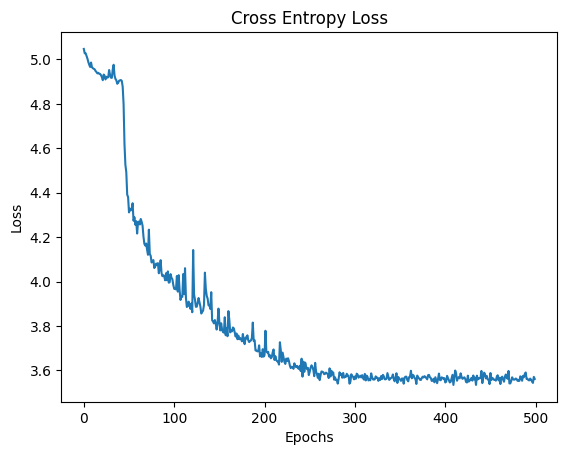

In [ ]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Cross Entropy Loss")
plt.show()

In [ ]:
torch.save(model, "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/best_entire_model2_CNN1D.pt")
np.save("/content/drive/MyDrive/TIDLLM/dataset/bsign22k/losses.npy", train_losses)

In [ ]:
### TODO: Add eval script

### Mapping from gloss ID to gloss name

In [ ]:
import pandas as pd

classes = pd.read_csv(f"/content/drive/MyDrive/TIDLLM/dataset/bsign22k/BosphorusSign22k_classes.csv")

key_value_pairs = classes.set_index('ClassID')['ClassName_tr'].to_dict()

key_value_pairs

In [ ]:
import json
with open(PATH+'gloss_id_pairs.json', 'w') as json_file:
    json.dump(key_value_pairs, json_file)

### TEST

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
model_file = "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/best_entire_model2_CNN1D.pt"
model = torch.load(model_file)

In [ ]:
PATH = "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/pose_array2/test/0075/User_4_001.npy"
test_data = torch.tensor(np.load(PATH))
print(test_data.shape)
print(test_data.unsqueeze(0).shape)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=PoseDistanceDataset.collate_fn)
label = PATH.split("/")[-2]
print(label)

torch.Size([6, 768])
torch.Size([1, 6, 768])
0075


In [ ]:
test_data = nn.ConstantPad2d((0, 0, 0, 16 - test_data.shape[0]), 0)(test_data)
arr = pad_sequence(test_data, batch_first=True, padding_value=0)
print(arr.shape)

torch.Size([16, 768])


In [ ]:
arr_b = arr.unsqueeze(0)
print(arr_b.shape)

torch.Size([1, 16, 768])


In [ ]:
with torch.no_grad():
    input = arr_b.to(DEVICE)
    #print(input.shape)
    out = model(input)
    print(torch.argmax(out), label)

tensor(93, device='cuda:0') 0075


### TEST ALL

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
model_file = "/content/drive/MyDrive/TIDLLM/dataset/bsign22k/best_entire_model2_CNN1D.pt"
model = torch.load(model_file)

In [19]:
test_dataset = PoseDistanceDataset(PATH, False)

In [23]:
len(test_dataset)

842

In [24]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=PoseDistanceDataset.collate_fn)

In [25]:
x,y = next(iter(test_dataloader))
print(x.shape, y.shape)

torch.Size([1, 16, 768]) torch.Size([1])


In [26]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    test_loss = 0.0
    test_acc = 0
    count=0
    for input, label in tqdm.tqdm(test_dataloader):
        count+=1
        input, label = input.to(DEVICE), label.to(DEVICE)
        out = model(input)
        loss_v = criterion(out, label)
        test_loss += loss_v.item()
        test_acc += (torch.argmax(out) == label).float().mean()

100%|██████████| 842/842 [08:07<00:00,  1.73it/s]
